In [2]:
import wfdb
import numpy as np
import pandas as pd
import glob
import os
from scipy.signal import resample

In [3]:
# Code to load all the signals
basePath="ECG_Database"

## List files and folders insade basePath
patDir = sorted(
    [f.path for f in os.scandir(basePath) if f.is_dir()],
    key=lambda x: int(os.path.basename(x).replace("patient", ""))  # Extraer el número de paciente
)

## Dictionary to store each patient's records
patDict = {}

def generateName(i, extension):
        return f"record{i:03d}{extension}" 

for patient in patDir:
    patID=os.path.basename(patient) # patID = directory name
    archivos = os.listdir(patient)

    # Create 3 lists, one for each file type 
    dat = [f for f in archivos if f.endswith(".dat")]
    hea = [f for f in archivos if f.endswith(".hea")]
    xyz = [f for f in archivos if f.endswith(".xyz")]

    # Rename the files for clarity
    
    import os

    # Agrupar los archivos por nombre base y asignarles un número secuencial
    allFiles = []
    
    # Agrupar los archivos con el mismo nombre base
    for f in dat + hea + xyz: 
        allFiles.append(f)  # Asignar el nuevo nombre

    patDict[patID] = {"files": allFiles}


In [ ]:
for patient, data in patDict.items():
    print(f"Paciente: {patient}")
    
    # Imprimir los archivos del paciente
    if "files" in data:
        print("Archivos:", ", ".join(data["files"]))
    else:
        print("No hay archivos registrados.")
    
    print("-" * 40)

In [ ]:
patient_path = list(patDict.keys())[0]  # Obtener la primera carpeta de paciente
dat_file = os.path.join(patient_path, patDict[patient_path]["files"][0])  # Primer archivo .dat
hea_file = dat_file.replace(".dat", ".hea")  # Archivo .hea correspondiente

print("Ruta del archivo .dat:", dat_file)
print("Ruta del archivo .hea:", hea_file)

In [42]:
import os

# Definir basePath y patient_id
basePath = "ECG_Database"
patient_id = "patient001"  # Ajusta esto si es necesario
patient_path = os.path.join(basePath, patient_id)  # Ruta completa

# Tomar el primer archivo válido en "dat"
dat_files = [f for f in patDict[patient_id]["files"] if not f.endswith(":Zone.Identifier")]

if not dat_files:
    raise FileNotFoundError("No se encontraron archivos .dat válidos para este paciente.")

# Construir la ruta completa del archivo .dat
dat_file = os.path.join(patient_path, dat_files[0])
base_path = os.path.splitext(dat_file)[0]  # Eliminar extensión

# Generar los archivos correspondientes
hea_file = os.path.normpath(base_path + ".hea")
xyz_file = os.path.normpath(base_path + ".xyz")

# Verificar si existen los archivos correctos
if os.path.exists(hea_file) and os.path.exists(dat_file):
    print("✅ Los archivos existen correctamente.")
else:
    print(f"❌ No se encontraron los archivos esperados.\n  - {hea_file}\n  - {dat_file}")

✅ Los archivos existen correctamente.


In [ ]:
import matplotlib.pyplot as plt
import wfdb
import os


# Seleccionar un paciente y su primer archivo de ECG
basePath = "ECG_Database"
for j in range(1,10):
    number=str(j).zfill(3)
    patient_id = "patient"+number  # Cambia esto si es necesario
    patient_path = os.path.join(basePath, patient_id)  # Ruta completa

    # 📌 Verificar los archivos disponibles en patDict
    print(f"Archivos en patDict[{patient_id}]:", patDict[patient_id]["files"])

    # Filtrar solo archivos que empiecen con "record" y sean .dat
    dat_files = [f for f in patDict[patient_id]["files"] if f.endswith(".dat") ]

    if not dat_files:
        raise FileNotFoundError(f"❌ No se encontraron archivos .dat válidos en {patient_id}")

    # Seleccionar el primer archivo válido
    i=0
    for file in dat_files :
        file_path = os.path.join(patient_path, file)
        file_base = os.path.splitext(file_path)[0]  # Eliminar extensión .dat
        print(f"📂 Leyendo archivo: {file_base}")
        # Leer el archivo de ECG
        record = wfdb.rdrecord(file_base)
        # Extraer la señal
        signal = record.p_signal

        # Graficar la primera derivación (Lead I)
        plt.plot(signal[:, 0])
        plt.title(f"ECG -  Derivación {i+1} ({patient_id})")
        plt.xlabel("Tiempo (muestras)")
        plt.ylabel("Amplitud")
        plt.show()
        i=i+1


# Verificar si los archivos existen antes de leer
if not os.path.exists(file_base + ".dat") or not os.path.exists(file_base + ".hea"):
    raise FileNotFoundError(f"⚠️ Falta algún archivo: {file_base}.dat o {file_base}.hea")



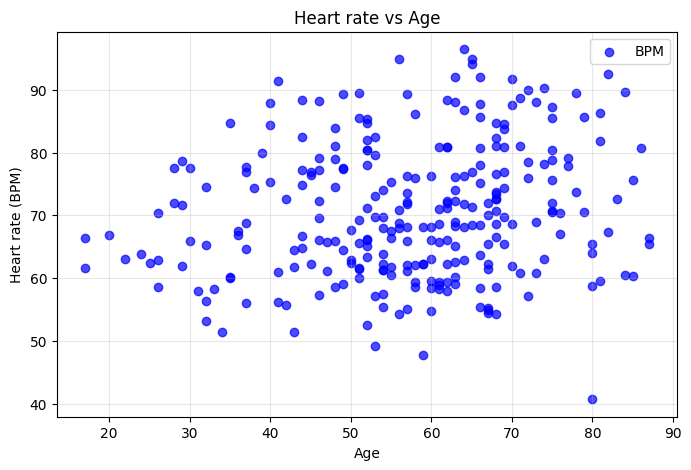

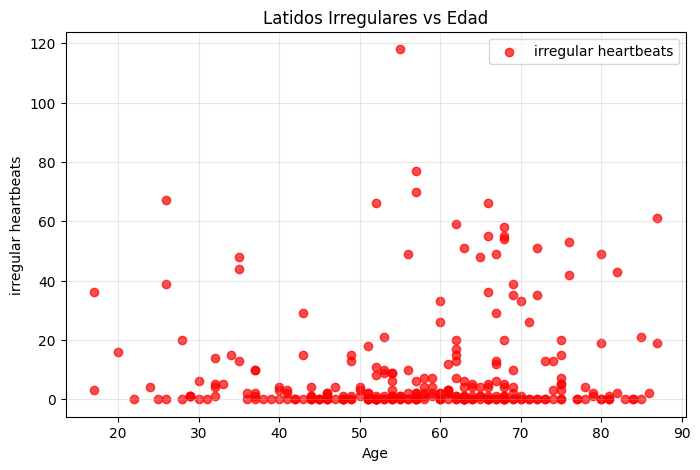

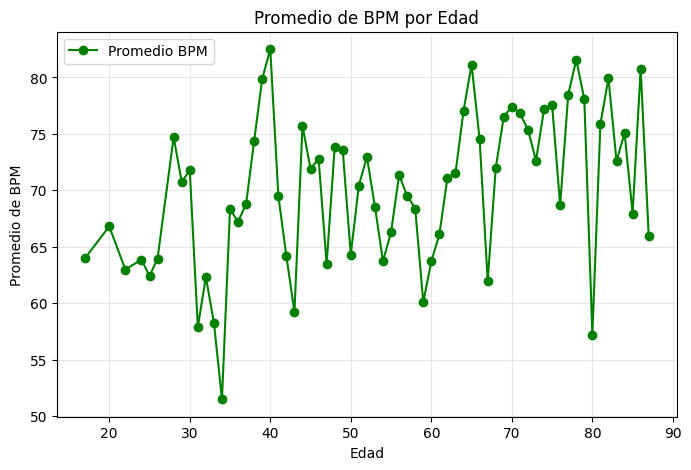

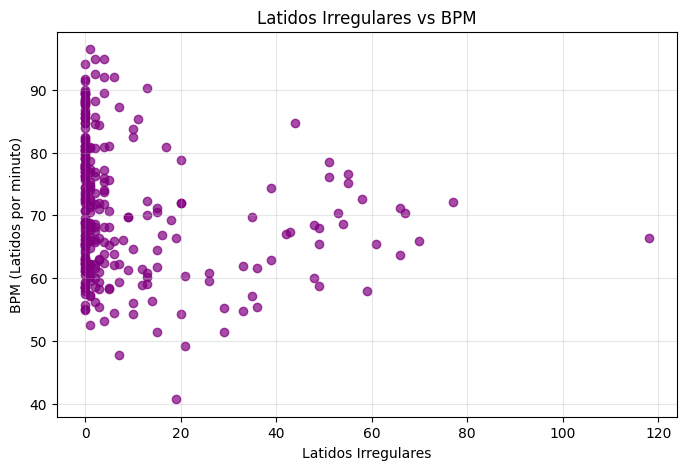

/tmp/ipykernel_860/2040629854.py:129: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df.groupby('Grupo Edad')['Latidos Irregulares'].mean().reset_index()


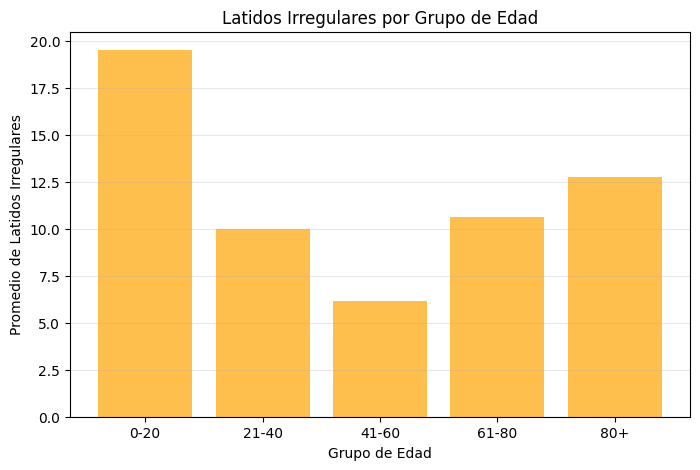

In [17]:
import wfdb
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# 📌 Listas para almacenar datos
edades = []
bpm_list = []
latidos_irregulares_list = []

# 📌 Recorrer todos los pacientes en patDict
for patient_id, data in patDict.items():
    archivos = data["files"]  # Lista de archivos del paciente
    
    # Buscar el archivo .dat y .hea (ECG + metadatos)
    dat_files = [f for f in archivos if f.endswith(".dat")]
    hea_files = [f for f in archivos if f.endswith(".hea")]
    
    if not dat_files or not hea_files:
        continue  # Saltar si faltan archivos

    # 📌 Tomar los archivos correspondientes
    basePath = "ECG_Database"
    file_path = os.path.join(basePath, patient_id, dat_files[0])
    file_base = os.path.splitext(file_path)[0]  # Sin extensión
    
    # 📌 Leer la edad desde el archivo .hea
    header = wfdb.rdheader(file_base)
    age = None
    for comment in header.comments:
        if "age:" in comment:
            try:
                age = int(comment.split(":")[1].strip())  # Extraer número
            except ValueError:
                pass

    if age is None:
        continue  # Si no se encuentra la edad, omitir paciente

    # 📌 Leer la señal ECG
    record = wfdb.rdrecord(file_base)
    signal = record.p_signal[:, 0]  # Usar la primera derivación
    fs = record.fs  # Frecuencia de muestreo

    # 📌 Detectar picos R
    peaks, _ = find_peaks(signal, height=np.mean(signal), distance=fs * 0.6)

    # 📌 Calcular BPM
    if len(peaks) > 1:
        rr_intervals = np.diff(peaks) / fs  # Intervalos RR en segundos
        bpm = 60 / np.mean(rr_intervals)  # BPM = 60 / Promedio de RR
    else:
        bpm = np.nan  # Si no hay suficientes picos, marcar como NaN

    # 📌 Calcular Latidos Irregulares
    if len(rr_intervals) > 1:
        umbral_irregularidad = np.mean(rr_intervals) * 0.2  # 20% de variabilidad
        latidos_irregulares = np.sum(np.abs(np.diff(rr_intervals)) > umbral_irregularidad)
    else:
        latidos_irregulares = np.nan

    # 📌 Guardar resultados
    edades.append(age)
    bpm_list.append(bpm)
    latidos_irregulares_list.append(latidos_irregulares)

# 📌 Gráfico de dispersión de BPM por Edad
plt.figure(figsize=(8, 5))
plt.scatter(edades, bpm_list, color="blue", alpha=0.7, label="BPM")
plt.xlabel("Age")
plt.ylabel("Heart rate (BPM)")
plt.title("Heart rate vs Age")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

# 📌 Gráfico de dispersión de Latidos Irregulares por Edad
plt.figure(figsize=(8, 5))
plt.scatter(edades, latidos_irregulares_list, color="red", alpha=0.7, label="irregular heartbeats")
plt.xlabel("Age")
plt.ylabel("irregular heartbeats")
plt.title("Latidos Irregulares vs Edad")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

import pandas as pd

# Crear un DataFrame con los datos de edad y BPM
df = pd.DataFrame({'Edad': edades, 'BPM': bpm_list})

# Eliminar las filas con valores NaN para asegurarnos de que las estadísticas sean válidas
df = df.dropna(subset=['BPM'])

# Agrupar por edad y calcular la media de BPM para cada grupo de edad
df_grouped = df.groupby('Edad')['BPM'].mean().reset_index()

# 📌 Graficar la media de BPM por Edad
plt.figure(figsize=(8, 5))
plt.plot(df_grouped['Edad'], df_grouped['BPM'], marker='o', color='green', label='Promedio BPM')
plt.xlabel("Edad")
plt.ylabel("Promedio de BPM")
plt.title("Promedio de BPM por Edad")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.scatter(latidos_irregulares_list, bpm_list, color='purple', alpha=0.7)
plt.xlabel("Latidos Irregulares")
plt.ylabel("BPM (Latidos por minuto)")
plt.title("Latidos Irregulares vs BPM")
plt.grid(alpha=0.3)
plt.show()

# 📌 Crear un DataFrame con las edades y los latidos irregulares
df = pd.DataFrame({'Edad': edades, 'Latidos Irregulares': latidos_irregulares_list})

# Eliminar filas con NaN
df = df.dropna(subset=['Latidos Irregulares'])

# 📌 Definir los rangos de edad
bins = [0, 20, 40, 60, 80, np.inf]
labels = ['0-20', '21-40', '41-60', '61-80', '80+']
df['Grupo Edad'] = pd.cut(df['Edad'], bins=bins, labels=labels, right=False)

# 📌 Calcular el promedio de latidos irregulares por grupo de edad
df_grouped = df.groupby('Grupo Edad')['Latidos Irregulares'].mean().reset_index()

# 📌 Gráfico de barras: Latidos Irregulares por Grupo de Edad
plt.figure(figsize=(8, 5))
plt.bar(df_grouped['Grupo Edad'], df_grouped['Latidos Irregulares'], color='orange', alpha=0.7)
plt.xlabel("Grupo de Edad")
plt.ylabel("Promedio de Latidos Irregulares")
plt.title("Latidos Irregulares por Grupo de Edad")
plt.grid(axis='y', alpha=0.3)
plt.show()



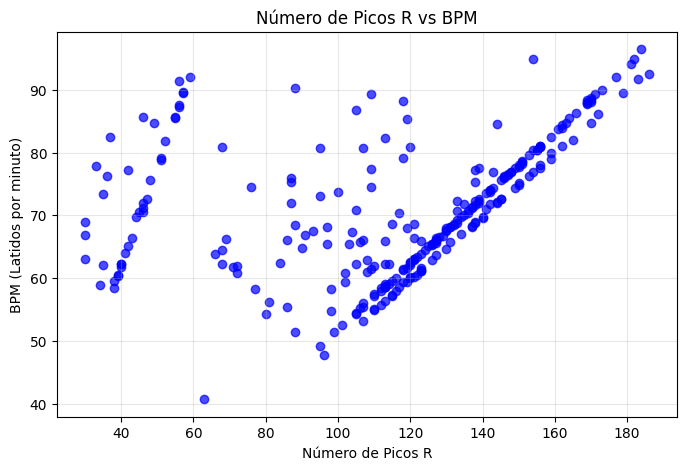

In [18]:
# 📌 Listas para almacenar datos
edades = []
bpm_list = []
latidos_irregulares_list = []
numero_picos_r_list = []

# 📌 Recorrer todos los pacientes en patDict
for patient_id, data in patDict.items():
    archivos = data["files"]  # Lista de archivos del paciente
    
    # Buscar el archivo .dat y .hea (ECG + metadatos)
    dat_files = [f for f in archivos if f.endswith(".dat")]
    hea_files = [f for f in archivos if f.endswith(".hea")]
    
    if not dat_files or not hea_files:
        continue  # Saltar si faltan archivos

    # 📌 Tomar los archivos correspondientes
    basePath = "ECG_Database"
    file_path = os.path.join(basePath, patient_id, dat_files[0])
    file_base = os.path.splitext(file_path)[0]  # Sin extensión
    
    # 📌 Leer la edad desde el archivo .hea
    header = wfdb.rdheader(file_base)
    age = None
    for comment in header.comments:
        if "age:" in comment:
            try:
                age = int(comment.split(":")[1].strip())  # Extraer número
            except ValueError:
                pass

    if age is None:
        continue  # Si no se encuentra la edad, omitir paciente

    # 📌 Leer la señal ECG
    record = wfdb.rdrecord(file_base)
    signal = record.p_signal[:, 0]  # Usar la primera derivación
    fs = record.fs  # Frecuencia de muestreo

    # 📌 Detectar picos R
    peaks, _ = find_peaks(signal, height=np.mean(signal), distance=fs * 0.6)
    
    # 📌 Calcular BPM
    if len(peaks) > 1:
        rr_intervals = np.diff(peaks) / fs  # Intervalos RR en segundos
        bpm = 60 / np.mean(rr_intervals)  # BPM = 60 / Promedio de RR
    else:
        bpm = np.nan  # Si no hay suficientes picos, marcar como NaN

    # 📌 Calcular Latidos Irregulares
    if len(rr_intervals) > 1:
        umbral_irregularidad = np.mean(rr_intervals) * 0.2  # 20% de variabilidad
        latidos_irregulares = np.sum(np.abs(np.diff(rr_intervals)) > umbral_irregularidad)
    else:
        latidos_irregulares = np.nan

    # 📌 Guardar resultados
    edades.append(age)
    bpm_list.append(bpm)
    latidos_irregulares_list.append(latidos_irregulares)
    numero_picos_r_list.append(len(peaks))

# 📌 Gráfico de dispersión: Número de picos R vs BPM
plt.figure(figsize=(8, 5))
plt.scatter(numero_picos_r_list, bpm_list, color='blue', alpha=0.7)
plt.xlabel("Número de Picos R")
plt.ylabel("BPM (Latidos por minuto)")
plt.title("Número de Picos R vs BPM")
plt.grid(alpha=0.3)
plt.show()


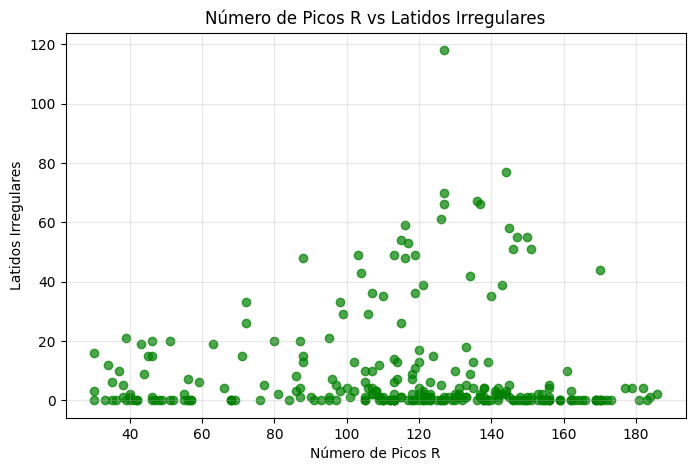

In [19]:
plt.figure(figsize=(8, 5))
plt.scatter(numero_picos_r_list, latidos_irregulares_list, color='green', alpha=0.7)
plt.xlabel("Número de Picos R")
plt.ylabel("Latidos Irregulares")
plt.title("Número de Picos R vs Latidos Irregulares")
plt.grid(alpha=0.3)
plt.show()